<a href="https://colab.research.google.com/github/katarinagresova/DeepFRI/blob/master/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/flatironinstitute/DeepFRI.git
%cd DeepFRI

Cloning into 'DeepFRI'...
remote: Enumerating objects: 672, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 672 (delta 59), reused 55 (delta 48), pack-reused 595
Receiving objects: 100% (672/672), 396.85 MiB | 25.86 MiB/s, done.
Resolving deltas: 100% (377/377), done.
Updating files: 100% (66/66), done.
/content/DeepFRI


In [2]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.5 MB/s eta 0:00:00


In [3]:
!wget https://users.flatironinstitute.org/~renfrew/DeepFRI_data/trained_models.tar.gz

--2023-08-23 05:51:41--  https://users.flatironinstitute.org/~renfrew/DeepFRI_data/trained_models.tar.gz
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 903786708 (862M) [application/octet-stream]
Saving to: ‘trained_models.tar.gz’

trained_models.tar. 100%[===================>] 861.92M  81.1MB/s    in 9.5s    

2023-08-23 05:51:51 (91.0 MB/s) - ‘trained_models.tar.gz’ saved [903786708/903786708]



In [4]:
!tar xvzf trained_models.tar.gz -C .

trained_models/
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_enzyme_commission_model_params.json
trained_models/DeepCNN-MERGED_molecular_function.hdf5
trained_models/DeepCNN-MERGED_cellular_component.hdf5
trained_models/lstm_lm.hdf5
trained_models/model_config.json
trained_models/DeepCNN-MERGED_enzyme_commission_model_params.json
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_cellular_component.hdf5
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_molecular_function_model_params.json
trained_models/DeepCNN-MERGED_cellular_component_model_params.json
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_enzyme_commission.hdf5
trained_models/DeepCNN-MERGED_biological_process_model_params.json
trained_models/DeepCNN-MERGED_enzyme_commission.hdf5
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_2048_ca_10A_biological_process.hdf5
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_molecular_functi

In [5]:
from deepfrier.utils import load_predicted_PDB, seq2onehot
import numpy as np

In [6]:
filename = "./examples/pdb_files/1S3P-A.pdb"
cmap_thresh=10.0

D, seq = load_predicted_PDB(filename)
A = np.double(D < cmap_thresh)

S = seq2onehot(seq)
S = S.reshape(1, *S.shape)
A = A.reshape(1, *A.shape)

/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 831
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 831
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/SeqIO/PdbIO.py:322: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  warnings.warn(


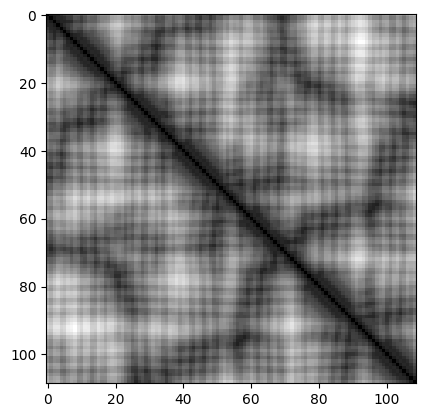

In [8]:
import matplotlib.pyplot as plt

plt.imshow(D)
plt.gray()
plt.show()

In [9]:
import tensorflow as tf
from deepfrier.layers import MultiGraphConv, GraphConv, FuncPredictor, SumPooling

model = tf.keras.models.load_model("./trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_molecular_function.hdf5",
                                                custom_objects={'MultiGraphConv': MultiGraphConv,
                                                                'GraphConv': GraphConv,
                                                                'FuncPredictor': FuncPredictor,
                                                                'SumPooling': SumPooling})

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq (InputLayer)               [(None, None, 26)]   0           []                               
                                                                                                  
 model (Functional)             (None, None, 1024)   3207168     ['seq[0][0]']                    
                                                                                                  
 LM_embedding (Dense)           (None, None, 1024)   1049600     ['model[0][0]']                  
                                                                                                  
 AA_embedding (Dense)           (None, None, 1024)   26624       ['seq[0][0]']                    
                                                                                            

In [16]:
model.layers[-2]

In [10]:
from keras.models import Model

encoder = Model(model.input, model.layers[-2].output)

In [11]:
y = encoder.predict([A, S])

1/1 [==============================] - 6s 6s/step


In [12]:
y

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
import pandas as pd

pd.DataFrame(y[0]).describe()

,0
count,1024.000000
mean,0.027637
std,0.201912
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.394846
